<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_8/8_5_Toy_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


device: cpu


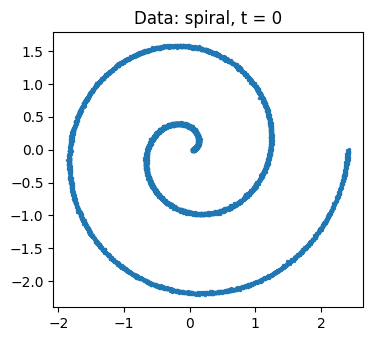

In [24]:
# Дані: проста 2D-спіраль

def make_spiral(n_samples=10_000, noise=0.02):
    t = torch.linspace(0, 4 * math.pi, n_samples)
    r = 0.1 + 0.4 * t            # радіус росте з кутом
    x = r * torch.cos(t)
    y = r * torch.sin(t)
    data = torch.stack([x, y], dim=-1)
    data = data + noise * torch.randn_like(data)
    # нормування для стабільності
    data = data / data.std(0, keepdim=True)
    return data

data = make_spiral().float()
dataset = TensorDataset(data)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

plt.figure(figsize=(4,4))
plt.scatter(data[:,0], data[:,1], s=2)
plt.title("Data: spiral, t = 0")
plt.gca().set_aspect("equal")
plt.show()

In [25]:
#  Параметри дифузії (DDPM-style)

T = 100   # число кроків дифузії
beta_start, beta_end = 1e-4, 0.02
betas  = torch.linspace(beta_start, beta_end, T, device=device)  # [T]
alphas = 1.0 - betas                                             # [T]
alpha_bars = torch.cumprod(alphas, dim=0) #кумулятивний добуток  # [T]


def q_sample(x0, t, noise=None):
    """
    Пряма дифузія:
    x_t = sqrt(ᾱ_t) * x_0 + sqrt(1 - ᾱ_t) * ε
    x0: [B, 2]
    t:  [B] (0..T-1)
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ab   = torch.sqrt(alpha_bars[t]).unsqueeze(-1)          # [B,1]
    sqrt_omab = torch.sqrt(1.0 - alpha_bars[t]).unsqueeze(-1)    # [B,1]
    return sqrt_ab * x0 + sqrt_omab * noise

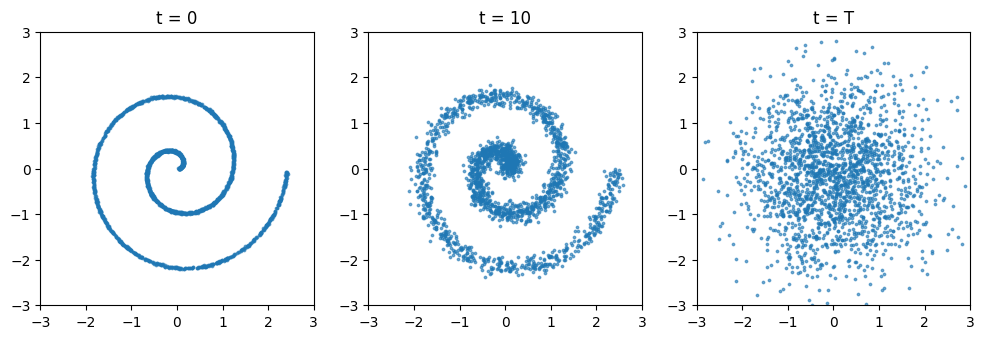

In [26]:
# Візуалізація прямої дифузії

with torch.no_grad():
    # випадкові 2000 точок
    idx = torch.randperm(data.size(0))[:2000]
    x0 = data[idx].to(device)

    # t = 0 ранній крок, t = T-1
    t0 = torch.zeros(x0.size(0), dtype=torch.long, device=device)
    mid_step = 10                           # крок
    tmid = torch.full_like(t0, mid_step)
    tT = torch.full_like(t0, T-1)

    x_t0   = x0                             # без шуму
    x_tmid = q_sample(x0, tmid)             # частково зашумлена спіраль
    x_tT   = q_sample(x0, tT)               # майже чистий Gaussian

def plot3(a, b, c):
    plt.figure(figsize=(12,4))
    for i, (x, title) in enumerate(zip(
        [a, b, c],
        [r"t = 0", fr"t = {mid_step}", r"t = T"]
    )):
        plt.subplot(1, 3, i+1)
        x = x.cpu()
        plt.scatter(x[:,0], x[:,1], s=3, alpha=0.6)
        plt.title(title)
        plt.xlim(-3,3); plt.ylim(-3,3)
        plt.gca().set_aspect("equal")
    plt.show()

plot3(x_t0, x_tmid, x_tT)

In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # pe: [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)          # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model] – для додавання до batch
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, T, d_model]
        x = x + self.pe[:, : x.size(1)]
        return x

In [28]:
# Модель ε_θ(x_t, t)

class TimeFromPosEnc(nn.Module):
    """Отримуємо time-embedding з PositionalEncoding."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # це клас з трансформера
        self.pos_enc = PositionalEncoding(d_model, max_len=max_len)

    def forward(self, t):
        """
        t: [B] ціле 0..T-1
        return: [B, d_model]
        """
        # гарантуємо правильний тип
        t = t.long()
        # pos_enc.pe має форму [1, max_len, d_model]
        # беремо потрібні позиції по індексу t
        emb = self.pos_enc.pe[0, t]      # [B, d_model]
        return emb


class EpsModel(nn.Module):
    """Простий MLP, який приймає (x_t, t) і повертає ε."""
    def __init__(self, time_dim=64, hidden=256, max_len=5000):
        super().__init__()
        # TimeEmbedding – обгортка над PositionalEncoding
        self.time_pe = TimeFromPosEnc(time_dim, max_len=max_len)

        self.net = nn.Sequential(
            nn.Linear(2 + time_dim, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, hidden),
            nn.LeakyReLU(0.01),
            nn.Linear(hidden, 2),
        )

    def forward(self, x_t, t):
        """
        x_t: [B, 2]
        t:   [B] (0..T-1)
        """
        t = t.to(x_t.device)  # переносимо t на той самий девайс
        t_emb = self.time_pe(t)                    # [B, time_dim]
        x = torch.cat([x_t, t_emb], dim=1)         # [B, 2 + time_dim]
        return self.net(x)

model = EpsModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)



In [29]:
#  Навчання: MSE(ε̂, ε)
n_epochs = 800

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0

    for (x0,) in loader:
        x0 = x0.to(device)
        B = x0.size(0)

        # випадкові кроки t для кожного зразка
        t = torch.randint(0, T, (B,), device=device)

        noise = torch.randn_like(x0)
        x_t = q_sample(x0, t, noise)

        eps_pred = model(x_t, t)
        loss = F.mse_loss(eps_pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * B

    avg_loss = total_loss / len(dataset)
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}/{n_epochs}, loss = {avg_loss:.5f}")


Epoch    1/800, loss = 0.82808
Epoch   50/800, loss = 0.65830
Epoch  100/800, loss = 0.63007
Epoch  150/800, loss = 0.60418
Epoch  200/800, loss = 0.62229
Epoch  250/800, loss = 0.61391
Epoch  300/800, loss = 0.60350
Epoch  350/800, loss = 0.61945
Epoch  400/800, loss = 0.60301
Epoch  450/800, loss = 0.60411
Epoch  500/800, loss = 0.61020
Epoch  550/800, loss = 0.59600
Epoch  600/800, loss = 0.60796
Epoch  650/800, loss = 0.59961
Epoch  700/800, loss = 0.60241
Epoch  750/800, loss = 0.60693
Epoch  800/800, loss = 0.61184


In [30]:
# Обернена дифузія: один крок t -> t-1

@torch.no_grad()
def p_sample_step(x_t, t):
    """
    DDPM-крок:
    x_{t-1} = 1/sqrt(α_t) * (x_t - (1-α_t)/sqrt(1-ᾱ_t) * ε̂ )
              + σ_t z,  де σ_t^2 = β̃_t
    """
    beta_t      = betas[t]
    alpha_t     = alphas[t]
    alpha_bar_t = alpha_bars[t]
    alpha_bar_prev = alpha_bars[t-1] if t > 0 else torch.tensor(1.0, device=device)

    eps_theta = model(x_t, torch.full(
        (x_t.size(0),), t, device=x_t.device, dtype=torch.long
    ))

    coef1 = 1.0 / torch.sqrt(alpha_t)
    coef2 = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)

    mean = coef1 * (x_t - coef2 * eps_theta)

    if t == 0:
        return mean
    else:
        beta_tilde = (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t) * beta_t
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(beta_tilde) * noise



In [31]:
# Повний обернений процес: від x_T ~ N(0, I) до x_0

@torch.no_grad()
def p_sample_loop(n_samples=2000):
    x_t = torch.randn(n_samples, 2, device=device)  # x_T
    for t in reversed(range(T)):
        x_t = p_sample_step(x_t, t)
    return x_t

samples = p_sample_loop(5000)



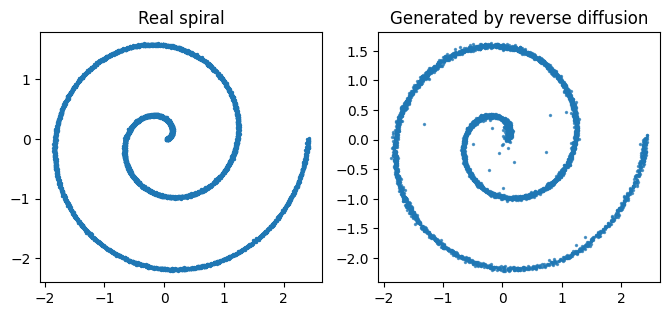

In [32]:
# Порівняння: справжні дані vs згенеровані

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(data[:,0], data[:,1], s=2)
plt.title("Real spiral")
plt.gca().set_aspect("equal")

plt.subplot(1,2,2)
plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), s=2, alpha=0.7)
plt.title("Generated by reverse diffusion")
plt.gca().set_aspect("equal")

plt.show()